/var/folders/9_/rht2jg897cgbskd7b32ypn140000gn/T/ipykernel_30895/2201215758.py:23: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/var/folders/9_/rht2jg897cgbskd7b32ypn140000gn/T/ipykernel_30895/2201215758.py:24: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

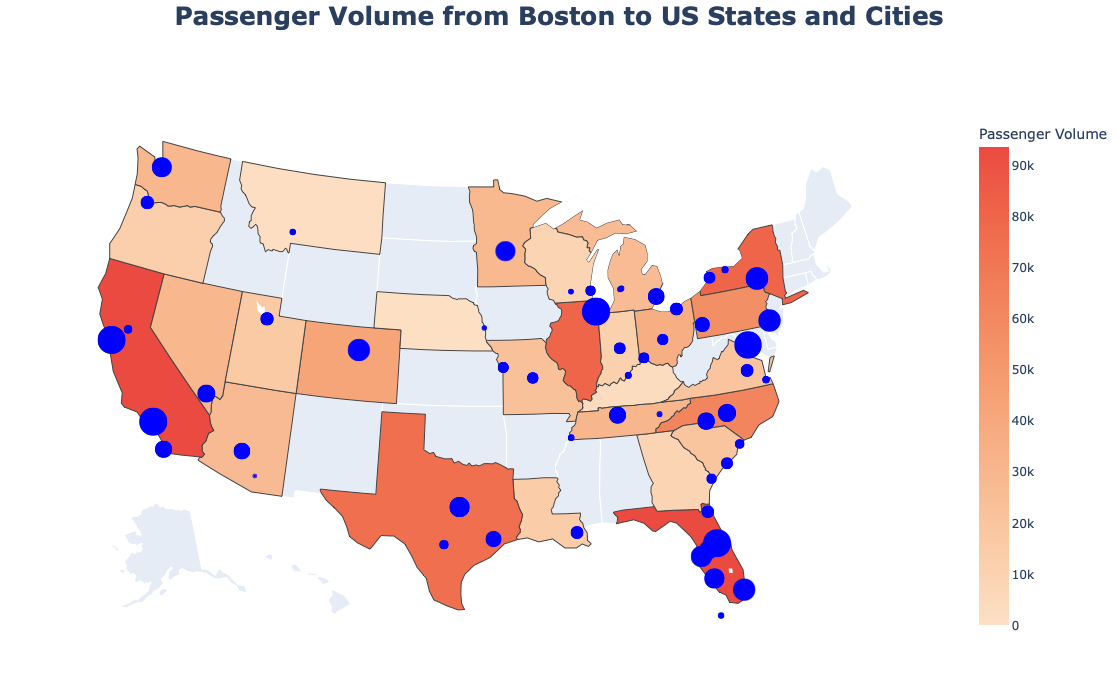

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import json


df = pd.read_csv('boston_flights.csv')
city_coordinates = pd.read_csv('us_cities_coordinates.csv')

df['city2'] = df['city2'].str.replace(r' \(Metropolitan Area\)', '', regex=True)

passenger_data = df[['city2', 'passengers']].copy()
passenger_data[['city', 'state']] = passenger_data['city2'].str.split(',', n=1, expand=True)
passenger_data['city'] = passenger_data['city'].str.strip()
passenger_data['state'] = passenger_data['state'].str.strip()

data_with_coords = pd.merge(passenger_data, city_coordinates, how='left', on=['city', 'state'])

missing_coords = data_with_coords[data_with_coords[['latitude', 'longitude']].isna().any(axis=1)]
state_centroids = city_coordinates.groupby('state').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()
data_with_coords = pd.merge(data_with_coords, state_centroids, on='state', how='left', suffixes=('', '_fallback'))

data_with_coords['latitude'].fillna(data_with_coords['latitude_fallback'], inplace=True)
data_with_coords['longitude'].fillna(data_with_coords['longitude_fallback'], inplace=True)

city_passenger_data = data_with_coords.copy()
state_passenger_data = passenger_data.groupby('state').agg({'passengers': 'sum'}).reset_index()

fig = px.choropleth(
    state_passenger_data,
    locations='state',
    locationmode='USA-states',
    color='passengers',
    color_continuous_scale=px.colors.sequential.Peach,
    range_color=(0, state_passenger_data['passengers'].quantile(0.90)),
    scope='usa',
    labels={'passengers': 'Passenger Volume'},
    title='<b>Passenger Volume from Boston to US States and Cities</b>'
)

scatter = go.Scattergeo(
    lat=city_passenger_data['latitude'],
    lon=city_passenger_data['longitude'],
    text=city_passenger_data['city2'],
    mode='markers',
    marker=dict(
        size=city_passenger_data['passengers'] / 10,
        color='blue',
        line=dict(width=0.0),
        sizemode='area'
    ),
    name='City Passenger Volume'
)

fig.add_trace(scatter)

fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
    margin={'r': 0, 't': 50, 'l': 0, 'b': 0},
    title_font_size=25,
    title_x=0.5,
    coloraxis_colorbar=dict(
        title='Passenger Volume',
 #       x=0.5,
  #      y=-0.3,
   #     orientation='h',
        thickness=30,
        len=0.8
    )
)

chart_json = fig.to_json()
with open('boston_flights_visualization.json', 'w') as json_file:
    json.dump(json.loads(chart_json), json_file)

fig.show()